In [273]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import io, stats
from fooof import FOOOFGroup

sys.path.append('../')
import utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)
C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [708]:
def plot_psd_figs(psd_dict, psd_re, p_cur, save_folder, region):
    for chan in range(psd_dict[p_cur].shape[1]):
        plt.loglog(psd_dict['f_axis'], psd_dict[p_cur][:,chan], 'k', lw=1)
        for psd_re in psds_regen:
            plt.loglog(psd_re[0],psd_re[1][chan,:], '-.', lw=2, alpha=0.8)

        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power (au)')    
        plt.title('Channel: %i - Region: %i'%(chan, region[chan]))
        plt.tight_layout()        
        plt.savefig(save_folder+'/chan%i_reg%i.png'%(chan, region[chan]))
        plt.clf()
        

# def compute_aggregate_by_region(df, feature, aggr_func, group_col=None):
#     if group_col in df.columns:
#         print('Aggregating over %s.'%group_col)
#         # group by specified column first and aggregate across electrodes of same region
#         df_region = pd.DataFrame()
#         for group_id, group in df.groupby(group_col):            
#             group_agg = group.groupby(['region']).aggregate(aggr_func)
#             df_region = df_region.append(group_agg)
            
#         grand_agg = df_region.groupby('region')
#     else:
#         # no base-level grouping, directly average across all electrodes
#         print('Aggregating over electrodes directly.')
#         df_region = df
#         grand_agg = df.groupby('region')
#     return grand_agg, df_region


def compute_aggregate(df, feature, aggr_func, group_col, loud=False):
    """
    Compute one- or two-level aggregate over the dataframe.
    """
    if len(group_col)==2:
        if loud: print('-> aggregating over %s.'%group_col[0])
        # group by specified column first and aggregate across specified types
        group_agg = pd.DataFrame()
        for group_id, group in df.groupby(group_col[0][0]):
            group_agg = group_agg.append(group.groupby(group_col[0][1]).aggregate(aggr_func))
        
        if loud: print('---> aggregating over %s.'%group_col[1])
        grand_agg = group_agg.groupby(group_col[1])

    elif len(group_col)==1 or type(group_col) is str:
        if type(group_col) is str:
            group_col = [group_col]
        # no first-level grouping, directly average across all electrodes
        if loud: print('-> aggregating over %s.'%group_col[0])
        group_agg = None
        grand_agg = df.groupby(group_col[0])
    return grand_agg, group_agg


def compute_avg_sem(grouped_by, feature, aggr_func):
    """
    Computes group average via aggr_func, and standard error.
    grouped_by must be a grouped_by dataframe
    """
    agg_avg = grouped_by[feature].apply(eval(aggr_func))
    agg_sem = grouped_by[feature].apply(np.nanstd)/(grouped_by[feature].count()**0.5)
    return agg_avg, agg_sem

def sort_per_lobe(sort_by_array, lobe_boundaries):
    reg_sorted_inds = []
    for i,l in enumerate(lobe_boundaries.T):
        reg_sorted_inds.append(sort_by_array[l[0]:l[1]].sort_values().index.values)
        #inverse_map.append(sort_by_array[l[0]:l[1]].ar sort_values().index.values)

    reg_sorted_inds = np.concatenate(reg_sorted_inds).astype(int)
    return reg_sorted_inds

def plot_aggregate_by_region(grand_agg, feature, aggr_func, region_labels, group_agg=None, log_y=True, m_cfg=['o','k',10], shade_by_lobe=False):
    
    lobe_boundaries = np.sort(np.array([region_labels.groupby('Lobe')['Region #'].min(), region_labels.groupby('Lobe')['Region #'].max()]))
    
    # compute and plot grand average and sem, sort x-axis by tau per lobe
    agg_avg, agg_sem = compute_avg_sem(grand_agg, feature, aggr_func)
    reg_sorted_inds = sort_per_lobe(agg_avg, lobe_boundaries)
    reverse_inds_map = pd.DataFrame(agg_avg.index.values, index=reg_sorted_inds)
    plt.errorbar(agg_avg.index, agg_avg[reg_sorted_inds], yerr=agg_sem*2., fmt=m_cfg[0]+m_cfg[1], ms=m_cfg[2], alpha=0.5)

    # plot per-subj average
    if group_agg is not None:
        for group_id, group in group_agg.groupby('patient'):
            # plot per-patient regional average
            #plt.plot(group[feature], 'k.', color=m_cfg[1], alpha=0.5, label=group_id, ms=m_cfg[2]/2)
            plt.plot(reverse_inds_map.loc[group.index.values.astype(int)], group[feature], 'k.', color=m_cfg[1], alpha=0.5, label=group_id, ms=m_cfg[2]/2)
    if log_y: plt.yscale('log')
        
    # label axes & ticks
    plt.xticks(region_labels['Region #'].values, region_labels['Region name'].values[reg_sorted_inds-1], rotation=300, ha='left', rotation_mode='anchor');
    # note the minus one because reg_sorted_inds are in terms of regions (1-38), but the array is 0-indexed
    plt.ylabel(feature, fontsize=18)
    plt.title(feature + ' - ' + aggr_func)
    
    # plot shading for lobe
    if shade_by_lobe:
        YL = plt.ylim()        
        for i,l in enumerate(lobe_boundaries.T):
            plt.fill_between([l[0]-0.5, l[1]+0.5], YL[0], YL[1], alpha=0.15, color=C_ORD[i])

    plt.box('off')
    plt.xlim([region_labels['Region #'].min()-0.5, region_labels['Region #'].max()+0.5])
    plt.tight_layout()
    

def plot_aggregate_by_region_hor(grand_agg, feature, aggr_func, region_labels, group_agg=None, log_x=True, m_cfg=['o','k',10], shade_by_lobe=False):
    
    lobe_boundaries = np.sort(np.array([region_labels.groupby('Lobe')['Region #'].min(), region_labels.groupby('Lobe')['Region #'].max()]))
    
    # compute and plot grand average and sem, sort x-axis by tau per lobe
    agg_avg, agg_sem = compute_avg_sem(grand_agg, feature, aggr_func)
    reg_sorted_inds = sort_per_lobe(agg_avg, lobe_boundaries)
    reverse_inds_map = pd.DataFrame(agg_avg.index.values, index=reg_sorted_inds)
    plt.errorbar(agg_avg[reg_sorted_inds], agg_avg.index, xerr=agg_sem*2., fmt=m_cfg[0]+m_cfg[1], ms=m_cfg[2], alpha=0.5)

    # plot per-subj average
    if group_agg is not None:
        for group_id, group in group_agg.groupby('patient'):
            # plot per-patient regional average
            #plt.plot(group[feature], 'k.', color=m_cfg[1], alpha=0.5, label=group_id, ms=m_cfg[2]/2)
            plt.plot(group[feature], reverse_inds_map.loc[group.index.values.astype(int)], 'k.', color=m_cfg[1], alpha=0.5, label=group_id, ms=m_cfg[2]/2)
    if log_x: plt.xscale('log')
        
    # label axes & ticks
    plt.yticks(region_labels['Region #'].values, region_labels['Region name'].values[reg_sorted_inds-1]);
    #plt.xticks(region_labels['Region #'].values, region_labels['Region name'].values[reg_sorted_inds-1], rotation=300, ha='left', rotation_mode='anchor');
    # note the minus one because reg_sorted_inds are in terms of regions (1-38), but the array is 0-indexed
    plt.xlabel(feature, fontsize=18)
    plt.title(feature + ' - ' + aggr_func)
    
    # plot shading for lobe
    if shade_by_lobe:
        XL = plt.xlim()        
        for i,l in enumerate(lobe_boundaries.T):
            plt.fill_betweenx([l[0]-0.5, l[1]+0.5], XL[0], XL[1], alpha=0.15, color=C_ORD[i])

    plt.box('off')
    plt.ylim([region_labels['Region #'].min()-0.5, region_labels['Region #'].max()+0.5])
    plt.tight_layout()
    

In [135]:
# load the data variables
basepath = '/Users/rdgao/Documents/data/MNI_rest/'
datafile = basepath + 'WakefulnessMatlabFile.mat'
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest/'
data_dict = io.loadmat(datafile, squeeze_me = True)
region_labels = pd.read_csv(basepath+'/WakefulnessInformation/RegionInformation.csv')
region_labels['Region name']=[rl[1:-1] for rl in region_labels['Region name']]
print(data_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 'Data', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])


# Saving out PSD & fooof fit plots
### note: this takes a long time because it's generating and saving thousands of plots

In [4]:
# set this to True to spit out a billion PSD & fooof fits
save_psd_plots = False

if save_psd_plots:
    # load in fooof results and regenerate fit psds
    plt.figure(figsize=(6,6))
    for win_len in ['1sec', '5sec']:
        for p_cur in ['psd_mean', 'psd_med']:
            psd_folder = result_basepath+'/psd/'+win_len+'/'
            psd_dict = np.load(psd_folder+'psds.npz')
            fooof_folder = psd_folder+'/fooof/'+p_cur+'/'        
            ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
            fgs, psds_regen = [], []
            for ff in ff_list:
                fg = FOOOFGroup()
                fg.load(ff, fooof_folder)
                fgs.append(fg)
                psds_regen.append(utils.return_fooof_regen(fg))

            psd_plot_save_folder = utils.makedir(fooof_folder, 'psd_plots/', timestamp=False)        
            plot_psd_figs(psd_dict, psds_regen, p_cur, psd_plot_save_folder, data_dict['ChannelRegion'])

# Collect fooof fits and meta info
Note that x,y,z in MNI coord is L-R, P-A, I-S 

In [382]:
win_len, p_cur = '1sec', 'psd_med'
fooof_folder = result_basepath+'/psd/'+win_len+'/fooof/'+p_cur+'/'
print(fooof_folder)
ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
print(ff_list)

# return fooof fits and convert knee to tau
fg_aps, fg_pks, fg_err, fg_r2s = utils.return_fg_fits(ff_list[1], fooof_folder)
if fg_aps.shape[1]==3:
    knee_freq, knee_tau = utils.convert_knee_val(fg_aps[:,1],fg_aps[:,2])
    knee = fg_aps[:,1]
else:
    knee_tau = np.zeros_like(fg_aps[:,0])
    knee = np.zeros_like(fg_aps[:,0])

# create pandas df and throw everything in there
e_type = np.array(data_dict['ChannelType'], 'c').view(np.uint8)-64.
df_info = np.vstack((data_dict['Patient'], e_type, data_dict['ChannelPosition'].T, data_dict['ChannelRegion'])).T
df_data = np.vstack((fg_aps[:,-1], knee, knee_tau, np.log10(knee_tau), fg_err, fg_r2s)).T
df_combined = pd.DataFrame(np.hstack((df_info,df_data)),columns=['patient','etype', 'x','y','z','region','exp', 'knee', 'tau','log_tau','err', 'r2'])

# insert lobe info
df_combined.insert(5, 'lobe', 0)
lobe_id = {val: ind for ind, val in enumerate(region_labels['Lobe'].unique())}
for ind, region in enumerate(region_labels['Region #']):
    df_combined.loc[df_combined['region']==ind,'lobe'] = lobe_id[region_labels.loc[ind,'Lobe']]    

# subsample by electrode type
print(df_combined.groupby('etype').count()['patient'])
print(df_combined[['exp','knee','tau','log_tau', 'err', 'r2']].corr('spearman'))

/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest//psd/1sec/fooof/psd_med/
['fg_fixed_1pks_30-55Hz.json', 'fg_knee_2pks_1-55Hz.json', 'fg_fixed_2pks_1-55Hz.json', 'fg_fixed_1pks_1-10Hz.json']
etype
1.0       66
4.0     1185
7.0      258
13.0     263
Name: patient, dtype: int64
              exp      knee       tau   log_tau       err        r2
exp      1.000000  0.967935 -0.830731 -0.830731  0.230530  0.113375
knee     0.967935  1.000000 -0.940439 -0.940439  0.259593 -0.024835
tau     -0.830731 -0.940439  1.000000  1.000000 -0.275740  0.212117
log_tau -0.830731 -0.940439  1.000000  1.000000 -0.275740  0.212117
err      0.230530  0.259593 -0.275740 -0.275740  1.000000 -0.765297
r2       0.113375 -0.024835  0.212117  0.212117 -0.765297  1.000000


../utils.py:55: RuntimeWarning: invalid value encountered in power
  knee_freq = knee**(1./exponent)


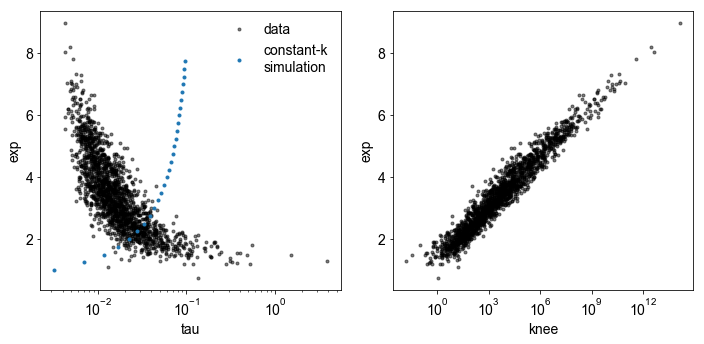

In [707]:
# plot tau-exp correlation
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.semilogx(df_combined['tau'],df_combined['exp'],'.k', alpha=0.5, label='data')
sim_exp = np.arange(1,8,0.25)
k_freq, k_tau = utils.convert_knee_val(knee=50., exponent=sim_exp)
plt.plot(k_tau, sim_exp, '.', label='constant-k\nsimulation')
plt.legend(frameon=False)
plt.xlabel('tau'); plt.ylabel('exp')
# knee-exp
plt.subplot(1,2,2)
plt.semilogx(df_combined['knee'],df_combined['exp'],'.k', alpha=0.5)
plt.xlabel('knee'); plt.ylabel('exp')
plt.tight_layout()

One immediate note of interest: exponent and time constant are negatively correlated, which is the opposite of what we would expect if purely a product of the time constant formula, i.e. knee remains constant but exponent changes.

This means exponent and time constant are independently changing and in opposite directions, in other words, slope and knee are positively correlated.

Does this recapitulate the Murray finding? Need to match convert the "long timescale" finding to exponent in the autocorrelation simulation.

# Subject and Grand Average
First average over electrodes of the same region for each subject, then average over all subjects.

Can vary the plotted feature and the central tendency measure used. Error bars always denote 2xSEM.

/Users/rdgao/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:842: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)


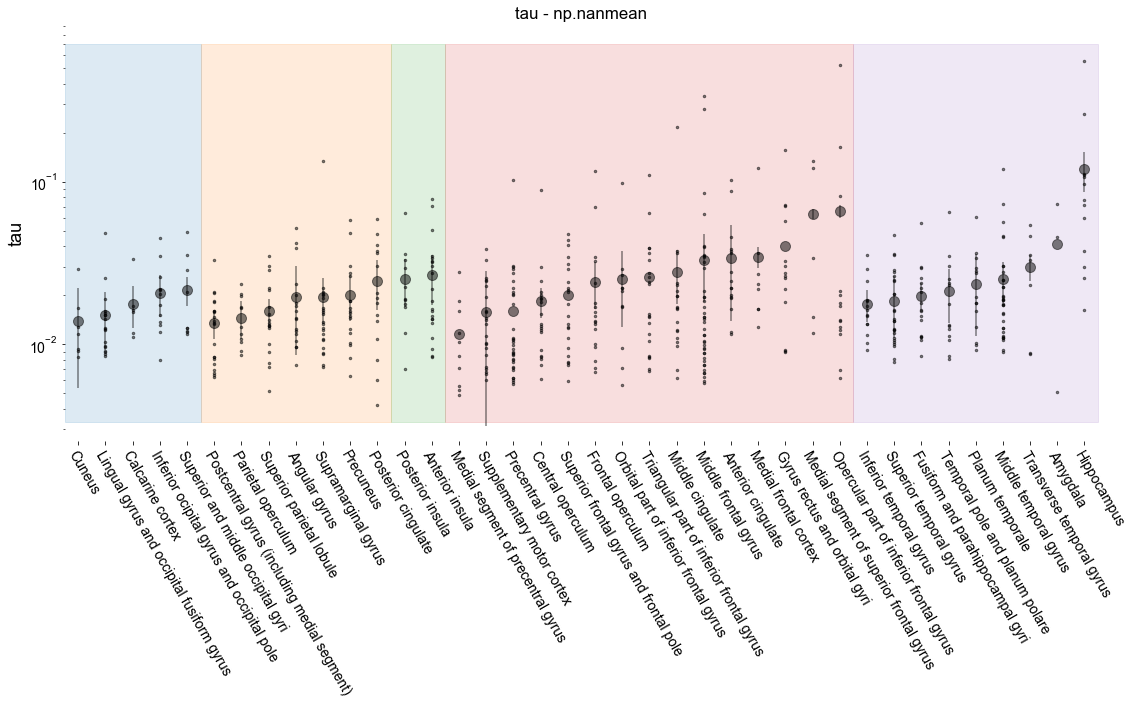

In [719]:
plt.figure(figsize=(16,10))
feature = 'tau'
group_col = [['patient', 'region'], 'region']
aggr_funcs = ['np.nanmean', 'np.nanmedian', 'stats.mstats.gmean']
aggr_func = aggr_funcs[0]
log_y = True

grand_agg_reg, patient_agg_reg = compute_aggregate(df_combined, feature, eval(aggr_func), group_col)
plot_aggregate_by_region(grand_agg_reg, feature, aggr_func, region_labels, patient_agg_reg, log_y=True, shade_by_lobe=True)
#plot_aggregate_by_region_hor(grand_agg_reg, feature, aggr_func, region_labels, patient_agg_reg, log_x=True, shade_by_lobe=True)

#### Interim conclusion: 
As far as time constants go, these results seem roughly consistent with the monkey results:
- the numbers themselves are in the range of monkey ecog results, i.e. between 10-100ms mostly, as opposed to 100-300ms of population spiking timescales
- frontal regions, especially mFC and ACC, have the longest fitted time constants.
- SMC and pre+postcentral gyrus (somatosensory areas) have the shortest time constants.
- temporal lobe, as a whole, have pretty long time constants. I would've expected at least a short-timescale region in primary auditory cortex, but maybe coverage there isn't good coverage there. Also I have no clue which of those regions correspond to A1.
- hippocampus has an extremely long time constant as a whole, as well as opercular part of IFG (brodmann 44).
- results are fairly consistent across different averaging functions
- did not look extensively across the different PSD estimate and fooof parameter configurations, but comparing 1sec and 5sec median fits seem to be pretty consistent

#### Problems:
- I have no idea where some of these regions are, maybe plot their average coordinates on a brain?
    - see next figure
- electrode difference: the 4 types of electrodes may have different impedance spectra, so I should probably regress that out, or at least compare within electrodes
    - see below: general pattern is more or less the same for each electrode type, though coverage does differ
- not really sure what is the best function to use to average/visualize the time constants, because they're non-normally distributed
    - have options for nanmean, nanmedian, and geometric mean, all more or less the same (though scipy geometric mean is messed up because it doesn't account for nans

# Plot on brain

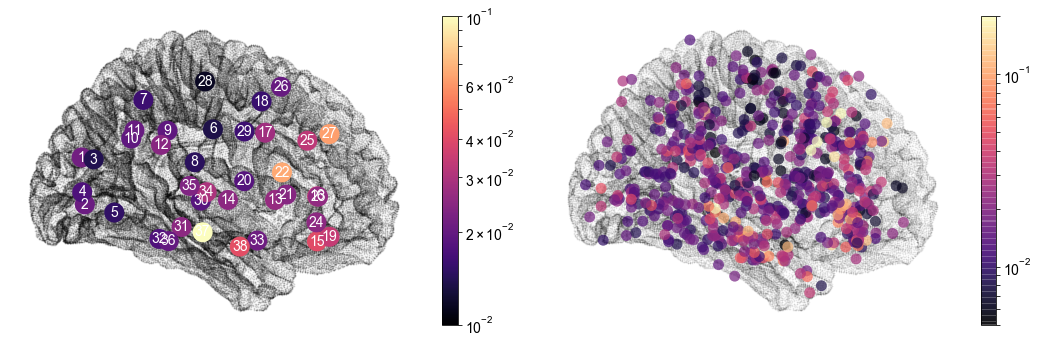

In [415]:
agg_avg, agg_sem = compute_avg_sem(grand_agg_reg, feature, aggr_func)
avg_coor = grand_agg_reg.mean()[['x','y','z']]

plt.figure(figsize=(15,5))

# plot grand average
plt.subplot(1,2,1)
plt.scatter(data_dict['NodesLeft'][:,1],data_dict['NodesLeft'][:,2], s=1, c='k', alpha=0.1) # plot brain
plt.scatter(avg_coor['y'],avg_coor['z'], s=400, c=agg_avg, 
            norm=matplotlib.colors.LogNorm(), edgecolors='none', cmap='magma')

for i,s in enumerate(region_labels['Region #']):
    plt.text(avg_coor['y'][i+1],avg_coor['z'][i+1], s, color='w', 
             horizontalalignment='center', verticalalignment='center')
plt.clim([0.01,0.1])
plt.colorbar()
plt.xticks([]);plt.yticks([])
plt.box('off')

# plot regional average from each patients
plt.subplot(1,2,2)
plt.scatter(data_dict['NodesLeft'][:,1],data_dict['NodesLeft'][:,2], s=1, c='k', alpha=0.05)
plt.scatter(patient_agg_reg['y'],patient_agg_reg['z'], s=120, c=patient_agg_reg[feature], 
            norm=matplotlib.colors.LogNorm(), edgecolors='none', cmap='magma', alpha=0.7)
plt.clim([0.005,0.2])
plt.colorbar()
plt.xticks([]);plt.yticks([])
plt.tight_layout()
plt.box('off')

# Subsample by electrode type

1.0 ['P', 'b', 10]
4.0 ['^', 'r', 10]


/Users/rdgao/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:842: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)


7.0 ['s', 'g', 10]
13.0 ['D', 'y', 10]


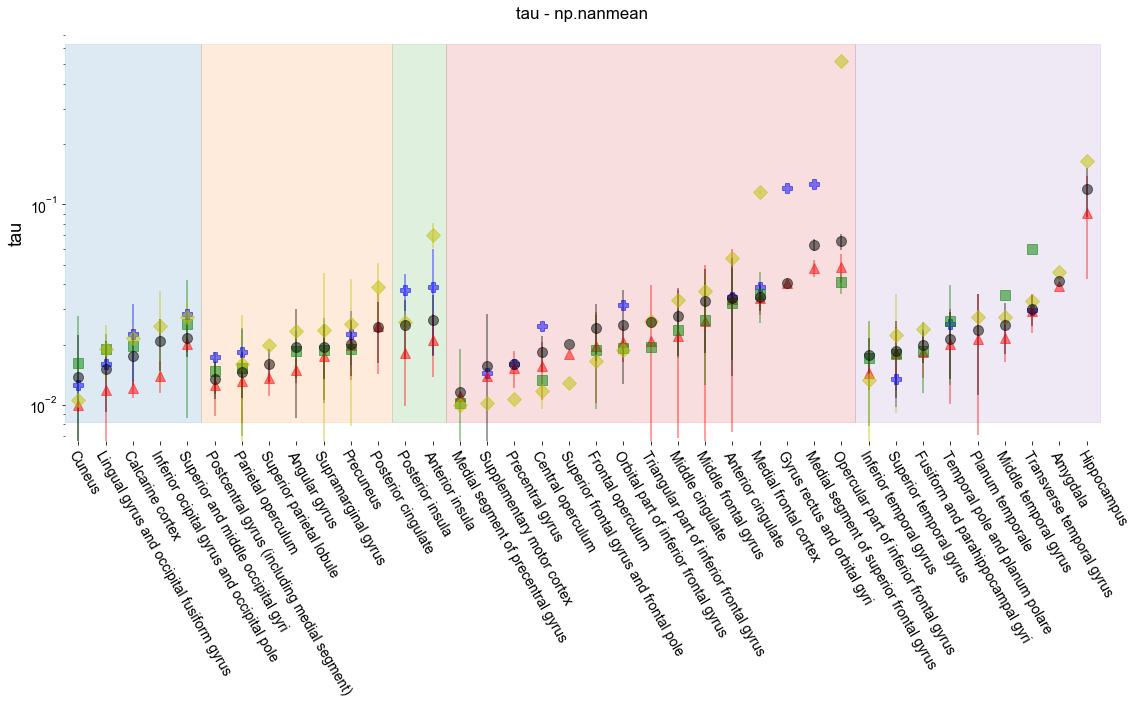

In [724]:
group_col = [['patient', 'region'], 'region']

plt.figure(figsize=(16,10))
# iterate through subsets
m_cfgs = [['P','b',10],['^','r',10],['s','g',10],['D','y',10]]
for i,e in enumerate(np.sort(df_combined['etype'].unique())):
    print(e, m_cfgs[i])
    sub_grand_agg_reg, patient_agg_reg = compute_aggregate(df_combined[df_combined['etype']==e], feature, eval(aggr_func), group_col)
    plot_aggregate_by_region(sub_grand_agg_reg, feature, aggr_func, region_labels, m_cfg=m_cfgs[i])

plot_aggregate_by_region(grand_agg_reg, feature, aggr_func, region_labels, shade_by_lobe=True)

- Black circles are grand average, green squares are grid/strip electrodes, the rest (blue/red/yellow) are stereo-EEG.
- It does not look like grid/strip electrodes are significantly different from the rest. Probably should run stats on this.

# Feature vs. Age

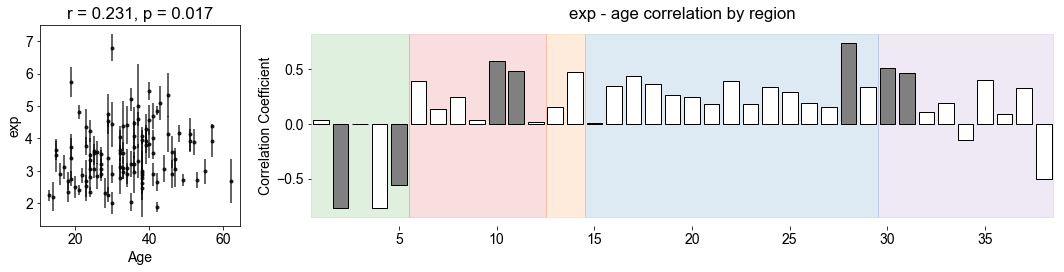

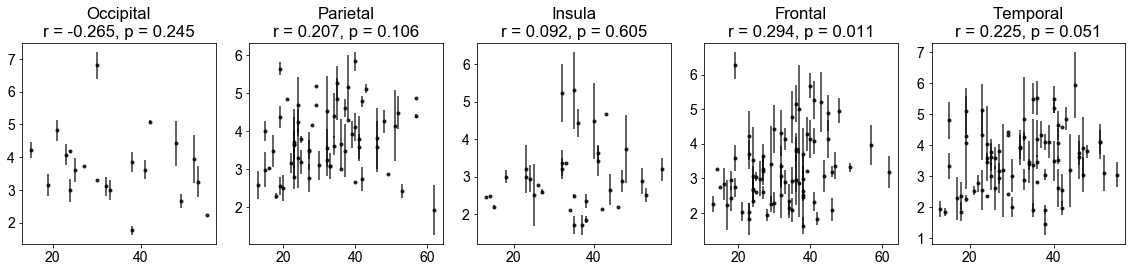

In [328]:
feature = 'exp'
group_col = 'patient'
#group_col = [['patient', 'region'], 'patient']
aggr_func = aggr_funcs[0]
sig_thres = 0.05
log_y = False
df_age = pd.DataFrame(data_dict['AgeAtTimeOfStudy'],index=df_combined.patient.unique())

plt.figure(figsize=(15,4))
# ---- grand average over patients ----
grand_agg_patient, _ = compute_aggregate(df_combined, feature, eval(aggr_func), group_col)
agg_avg, agg_sem = compute_avg_sem(grand_agg_patient, feature, aggr_func)
rho, pv = stats.spearmanr(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, nan_policy='omit')

plt.subplot2grid((1, 4), (0, 0),colspan=1)
plt.errorbar(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, agg_sem*2, fmt='.k', alpha=0.8)
plt.xlabel('Age'); plt.ylabel(feature); plt.title('r = %.3f, p = %.3f'%(rho, pv))
if log_y: plt.yscale('log')

# ---- average per region ----
plt.subplot2grid((1, 4), (0, 1),colspan=4)
for ind, region in enumerate(np.sort(df_combined['region'].unique())):
    sub_agg_reg, _ = compute_aggregate(df_combined[df_combined['region']==region], feature, eval(aggr_func), group_col)
    agg_avg, agg_sem = compute_avg_sem(sub_agg_reg, feature, aggr_func)
    rho, pv = stats.spearmanr(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, nan_policy='omit')
    plt.bar(region, rho, ec='k', fc='w' if pv > sig_thres else 'gray')

# plot shading for lobe
YL = plt.ylim()
lobes = np.array([region_labels.groupby('Lobe')['Region #'].min(), region_labels.groupby('Lobe')['Region #'].max()])
for i,l in enumerate(lobes.T):
    plt.fill_between([l[0]-0.5, l[1]+0.5], YL[0], YL[1], alpha=0.15, color=C_ORD[i])

    
plt.xlim([region_labels['Region #'].min()-0.5, region_labels['Region #'].max()+0.5])
plt.ylabel('Correlation Coefficient')
plt.title(feature+' - age correlation by region')
plt.box('off')
plt.tight_layout()

# ---- per lobe --- #
plt.figure(figsize=(16,4))
for ind, lobe in enumerate(lobe_id.keys()):
    sub_agg_lobe, _ = compute_aggregate(df_combined[df_combined['lobe']==lobe_id[lobe]], feature, eval(aggr_func), group_col)
    agg_avg, agg_sem = compute_avg_sem(sub_agg_lobe, feature, aggr_func)
    plt.subplot2grid((1, 5), (0, ind))
    plt.errorbar(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, agg_sem*2, fmt='.k', alpha=0.8)
    if log_y: plt.yscale('log')
    rho, pv = stats.spearmanr(df_age.loc[np.array(agg_avg.index).astype(int),0], agg_avg, nan_policy='omit')
    plt.title(lobe+'\nr = %.3f, p = %.3f'%(rho, pv))

plt.tight_layout()

In [281]:
# def plot_by_region(df, aggr_func, plot_feature='tau', log_y=True, m_cfg=['o','k',10], shade_by_lobe=False):
#     df_region = pd.DataFrame()

#     # plot per-subj average
#     for patient, group in df.groupby('patient'):
#         # group by patient and aggregate across electrodes of same region
#         patient_agg = group.groupby(['region']).aggregate(eval(aggr_func))
#         df_region = df_region.append(patient_agg)
#         # plot per-patient regional average
#         plt.plot(patient_agg[plot_feature], m_cfg[0], alpha=0.5, label=patient, ms=m_cfg[2]/2)

#     # plot grand average and sem
#     grand_agg = df_region.groupby('region')
#     agg_mean = grand_agg[plot_feature].apply(eval(aggr_func))
#     agg_std = grand_agg[plot_feature].apply(np.nanstd)/(grand_agg[plot_feature].count()**0.5)*2
#     plt.errorbar(agg_mean.index, agg_mean, yerr=agg_std, fmt=m_cfg[0]+m_cfg[1], ms=m_cfg[2], alpha=0.5)

#     if log_y: plt.yscale('log')

#     # label axes & ticks
#     plt.xticks(region_labels['Region #'], region_labels['Region name'], rotation=300, ha='left', rotation_mode='anchor');
#     plt.ylabel(plot_feature, fontsize=18)
#     plt.title(plot_feature + ' - ' + aggr_func)
    
#     if shade_by_lobe:
#         # plot shading for lobe
#         YL = plt.ylim()
#         lobes = np.array([region_labels.groupby('Lobe')['Region #'].min(), region_labels.groupby('Lobe')['Region #'].max()])
#         for l in lobes.T:
#             plt.fill_between([l[0]-0.5, l[1]+0.5], YL[0], YL[1], alpha=0.15)

#     plt.box('off')
#     plt.xlim([region_labels['Region #'].min()-0.5, region_labels['Region #'].max()+0.5])
#     plt.tight_layout()
#     return df_region, grand_agg

# plt.figure(figsize=(16,10))
# plot_feature = 'tau'
# aggr_funcs = ['np.nanmean', 'np.nanmedian', 'stats.mstats.gmean']
# aggr_func = aggr_funcs[0]
# log_y = True

# df_region, df_agg = plot_by_region(df_combined, aggr_func, shade_by_lobe=True)

# # # iterate through subsets
# # m_cfgs = [['P','b',10],['^','r',10],['s','g',10],['D','y',10]]
# # for i,e in enumerate(df_combined['etype'].unique()):
# #     plot_by_region(df_combined[df_combined['etype']==e], aggr_func, m_cfg=m_cfgs[i])

# plot_aggr_by_region(test_out_pat[0], 'tau', aggr_funcs[0], m_cfg=m_cfgs[1])

Text(0,0.5,'Time constant (s)')

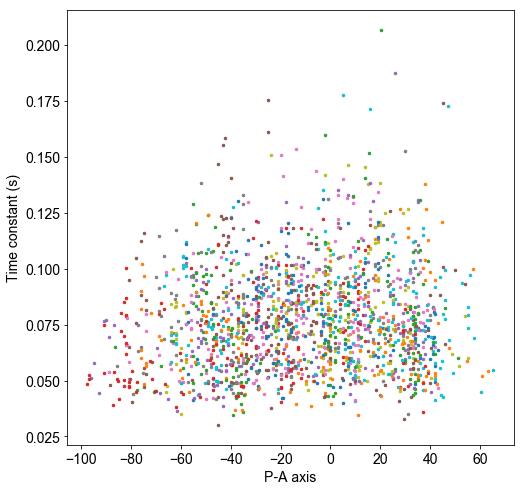

In [375]:
# 'D' for Dixi intracerebral electrodes
# 'M' for homemade MNI intracerebral electrodes
# 'A' fro AdTech intracerebral electrodes 
# 'G' for AdTech subdural strips and grids
plt.figure(figsize=(8,8))
inds = np.logical_and(data_dict['ChannelType']=='M',~np.isnan(knee_freq))
for p in np.unique(data_dict['Patient']):
    inds = np.logical_and(data_dict['Patient']==p,~np.isnan(knee_freq))
    plt.plot(data_dict['ChannelPosition'][inds,1], fg_err[inds], '.', ms=5)

plt.xlabel('P-A axis')
plt.ylabel('Time constant (s)')

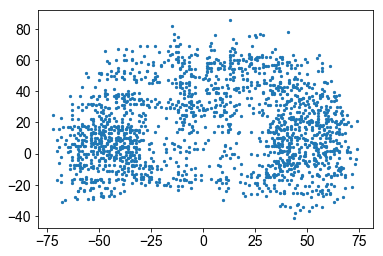

In [27]:
ind = data_dict['ChannelPosition'][:,0]>=-np.inf
plt.scatter(data_dict['ChannelPosition'][ind,0], data_dict['ChannelPosition'][ind,2], 5)

In [28]:
# Extract aperiodic data
aps = fg.get_all_data('aperiodic_params')
exps = fg.get_all_data('aperiodic_params', 'exponent')

# Extract peak data
peaks = fg.get_all_data('peak_params')
cfs = fg.get_all_data('peak_params', 'CF')

# Extract metadata about the model fit
errors = fg.get_all_data('error')
r2s = fg.get_all_data('r_squared')

In [5]:
# load fooof result
fooof_file = 

dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 'Data', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])
